In [5]:
import torchvision
import matplotlib.pyplot as plt
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.training.supervised import Naive
from avalanche.models import SlimResNet18
from avalanche.benchmarks import with_task_labels, benchmark_from_datasets
from utils import load_CLEAR, build_CLEAR_experiences

In [3]:
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
train_transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((32, 32)),
            #normalize,
        ]
    )
folder_path = '/Users/marcodamommio/2023-2024_OCL_Class-Incremental/train/labeled_images'
images_dict = load_CLEAR(folder_path, transform=train_transform)

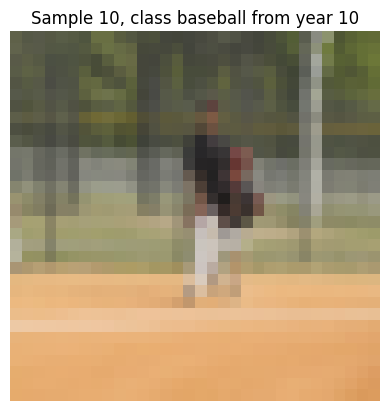

In [8]:
year_folder_name = '10'
class_folder_name = 'baseball'
images_array = images_dict[year_folder_name][class_folder_name]

elem = 10
plt.imshow(images_array[elem].permute(1,2,0))
plt.axis('off')  # Nascondere gli assi
plt.title(f'Sample {elem}, class {class_folder_name} from year {year_folder_name}')
plt.show()

In [9]:
classes_pair = [
    ('BACKGROUND', 'baseball'),
    ('bus', 'camera'),
    ('cosplay', 'dress'),
    ('hockey', 'laptop'),
    ('racing', 'soccer'),
    ('sweater', None)   
]

In [10]:
experiences = build_CLEAR_experiences(images_dict, classes_pair)

In [11]:
bm = with_task_labels(benchmark_from_datasets(train=experiences))
bm

In [12]:
# TRAINING LOOP
print('Starting experiment...')
results = []
for experience in bm.train_stream:
    print("Start of experience: ", experience.current_experience)

    # in Avalanche an experience may have multiple task labels
    # if the samples in its dataset come from different tasks
    # here we just have one task label per experience
    print(f"\tTask labels: {experience.task_labels}")

    #cl_strategy.train(experience)
    print('Training completed')

Starting experiment...
Start of experience:  0
	Task labels: {0}
Training completed
Start of experience:  1
	Task labels: {0}
Training completed
Start of experience:  2
	Task labels: {0}
Training completed
Start of experience:  3
	Task labels: {0}
Training completed
Start of experience:  4
	Task labels: {0}
Training completed
Start of experience:  5
	Task labels: {0}
Training completed
Start of experience:  6
	Task labels: {0}
Training completed
Start of experience:  7
	Task labels: {0}
Training completed
Start of experience:  8
	Task labels: {0}
Training completed
Start of experience:  9
	Task labels: {0}
Training completed
Start of experience:  10
	Task labels: {0}
Training completed
Start of experience:  11
	Task labels: {0}
Training completed
Start of experience:  12
	Task labels: {0}
Training completed
Start of experience:  13
	Task labels: {0}
Training completed
Start of experience:  14
	Task labels: {0}
Training completed
Start of experience:  15
	Task labels: {0}
Training compl